In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


**READ THE DATASET**

In [3]:
train_label = pd.read_csv('fraud_analysis_data\Train_data.csv')
train_IP = pd.read_csv('fraud_analysis_data\Train_IP_data.csv')
train_OP = pd.read_csv('fraud_analysis_data\Train_OP_data.csv')
train_BF = pd.read_csv('fraud_analysis_data\Train_Benef_data.csv')

test_IP = pd.read_csv('fraud_analysis_data\Test_IP_data.csv')
test_OP = pd.read_csv('fraud_analysis_data\Test_OP_data.csv')
test_BF = pd.read_csv('fraud_analysis_data\Test_BF_data.csv')
test_label = pd.read_csv('fraud_analysis_data\Test_data.csv')

In [5]:
train_OP.shape

(517737, 27)

In [8]:
train_IP.shape

(40474, 30)

In [7]:
train_BF.shape

(138556, 25)

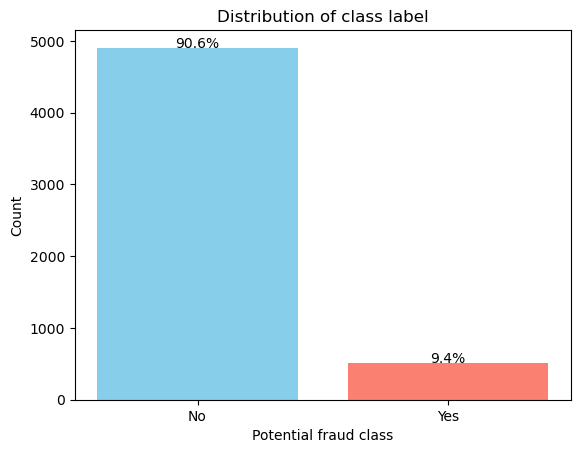

In [9]:
import matplotlib.pyplot as plt

count = train_label['PotentialFraud'].value_counts()

# Creating the bar plot with different colors
colors = ['skyblue', 'salmon']
plt.bar(count.index, count.values, color=colors)

# Adding labels and title
plt.xlabel('Potential fraud class')
plt.ylabel('Count')
plt.title('Distribution of class label')

# Adding percentages above each bar
total = count.sum()
for i, v in enumerate(count.values):
    percent = (v / total) * 100
    plt.text(i, v + 5, f'{percent:.1f}%', ha='center')

# Displaying the plot
plt.show()


**DATA PREPROCESS**

In [10]:
def preprocess_data(df_label, df_beneficiary, df_inpatient, df_outpatient):

  ### replace the various chronicdisease indicator, 0 Indicate the absence, 1 indicates presence
  df_beneficiary = df_beneficiary.replace({'ChronicCond_Alzheimer': 2, 'ChronicCond_Heartfailure': 2, 'ChronicCond_KidneyDisease': 2,
                               'ChronicCond_Cancer': 2, 'ChronicCond_ObstrPulmonary': 2, 'ChronicCond_Depression': 2,
                               'ChronicCond_Diabetes': 2, 'ChronicCond_IschemicHeart': 2, 'ChronicCond_Osteoporasis': 2,
                               'ChronicCond_rheumatoidarthritis': 2, 'ChronicCond_stroke': 2 }, 0)

  ### replace the presence of  RenalDiseaseIndicator as 1
  df_beneficiary=df_beneficiary.replace({'RenalDiseaseIndicator':'Y'},1)
  df_beneficiary['RenalDiseaseIndicator']=df_beneficiary['RenalDiseaseIndicator'].astype('int64')

  ### change the  categorical datatype column to numeric datatype
  df_beneficiary[["ChronicCond_Alzheimer", "ChronicCond_Heartfailure", "ChronicCond_KidneyDisease", "ChronicCond_Cancer", "ChronicCond_ObstrPulmonary", "ChronicCond_Depression", "ChronicCond_Diabetes", "ChronicCond_IschemicHeart", "ChronicCond_Osteoporasis", "ChronicCond_rheumatoidarthritis", "ChronicCond_stroke", "RenalDiseaseIndicator"]] = df_beneficiary[["ChronicCond_Alzheimer", "ChronicCond_Heartfailure", "ChronicCond_KidneyDisease", "ChronicCond_Cancer", "ChronicCond_ObstrPulmonary", "ChronicCond_Depression", "ChronicCond_Diabetes", "ChronicCond_IschemicHeart", "ChronicCond_Osteoporasis", "ChronicCond_rheumatoidarthritis", "ChronicCond_stroke", "RenalDiseaseIndicator"]].apply(pd.to_numeric)

  ### replace the  '2' with  '0' for gender type
  df_beneficiary=df_beneficiary.replace({'Gender': 2}, 0)

  ### create a new feature for understaning the nature of patient  in terms of DOD
  ### set is_dead=1 for patient that has DOD and  0 for null
  df_beneficiary.loc[df_beneficiary['DOD'].isnull(), 'is_dead'] = 0
  df_beneficiary.loc[df_beneficiary['DOD'].notnull(), 'is_dead'] = 1

  ### Convert Date of Birth and Date of Death from String to Datetime format
  df_beneficiary['DOB'] = pd.to_datetime(df_beneficiary['DOB'] , format = '%Y-%m-%d')
  df_beneficiary['DOD'] = pd.to_datetime(df_beneficiary['DOD'],format = '%Y-%m-%d')

  ### calculate age of the patient
  df_beneficiary['Patient_Age'] = round(((df_beneficiary['DOD'] - df_beneficiary['DOB']).dt.days)/365)
  df_beneficiary.Patient_Age.fillna(round(((pd.to_datetime('2009-12-01',format ='%Y-%m-%d')-df_beneficiary['DOB']).dt.days)/365),inplace=True)

  ### convert the ClaimStartDt, ClaimEndDt from string to datetime format
  df_inpatient['ClaimStartDt'] = pd.to_datetime(df_inpatient['ClaimStartDt'] , format = '%Y-%m-%d')
  df_inpatient['ClaimEndDt'] = pd.to_datetime(df_inpatient['ClaimEndDt'],format = '%Y-%m-%d')

  ### convert the AdmissionDt, DischargeDt from string to datetime format
  df_inpatient['AdmissionDt'] = pd.to_datetime(df_inpatient['AdmissionDt'] , format = '%Y-%m-%d')
  df_inpatient['DischargeDt'] = pd.to_datetime(df_inpatient['DischargeDt'],format = '%Y-%m-%d')

  ### Calculate Hospitalization_Duration = DischargeDt - AdmissionDt
  df_inpatient['Hospitalization_Duration'] = ((df_inpatient['DischargeDt'] - df_inpatient['AdmissionDt']).dt.days)+1

  ### Calculate Claim_Period = ClaimEndDt - ClaimStartDt
  df_inpatient['Claim_Period'] = ((df_inpatient['ClaimEndDt'] - df_inpatient['ClaimStartDt']).dt.days)+1

  ### ExtraClaimDays = Claim_Period - Hospitalization_Duration
  ### np.where(condition, x, y)
  df_inpatient['ExtraClaimDays'] = np.where(df_inpatient['Claim_Period']>df_inpatient['Hospitalization_Duration'], df_inpatient['Claim_Period'] - df_inpatient['Hospitalization_Duration'], 0)

  ### convert the ClaimStartDt, ClaimEndDt from string to datetime format

  df_outpatient['ClaimStartDt'] = pd.to_datetime(df_outpatient['ClaimStartDt'] , format = '%Y-%m-%d')
  df_outpatient['ClaimEndDt'] = pd.to_datetime(df_outpatient['ClaimEndDt'],format = '%Y-%m-%d')

  ### Calculate Claim_Period = ClaimEndDt - ClaimStartDt
  df_outpatient['Claim_Period'] = ((df_outpatient['ClaimEndDt'] - df_outpatient['ClaimStartDt']).dt.days)+1

  ### create a new feature for understaning the nature of patient in  terms of inpatient and outpatient
  ### set is_admistted=1 for inpatient and 0 for outpatient
  df_inpatient['is_admitted'] = 1
  df_outpatient['is_admitted'] = 0

  ### MERGE THE DATASET

  ###Merge inpatient and outpatient dataframes based on common columns
  common_columns = [ idx for idx in df_outpatient.columns if idx in df_inpatient.columns]
  IP_OP_MERGE = pd.merge(df_inpatient, df_outpatient, left_on = common_columns, right_on = common_columns,how = 'outer')

  ### Merge beneficiary details with inpatient and outpatient data
  Inpatient_Outpatient_Beneficiary_Merge = pd.merge(IP_OP_MERGE, df_beneficiary,left_on='BeneID',right_on='BeneID',how='inner')
  Final_Dataset = pd.merge(Inpatient_Outpatient_Beneficiary_Merge, df_label ,how = 'inner', on = 'Provider')

  return Final_Dataset



DATA SET AFTER PREPROCESSING

In [12]:

final_dataset_preprocess = pd.DataFrame()
final_dataset_preprocess= preprocess_data(train_label, train_BF, train_IP, train_OP)


NATURE OF DATASET

In [13]:
final_dataset_preprocess.dtypes

BeneID                              object
ClaimID                             object
ClaimStartDt                datetime64[ns]
ClaimEndDt                  datetime64[ns]
Provider                            object
                                 ...      
OPAnnualReimbursementAmt             int64
OPAnnualDeductibleAmt                int64
is_dead                            float64
Patient_Age                        float64
PotentialFraud                      object
Length: 61, dtype: object

In [14]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
final_dataset_preprocess.isnull().sum()

BeneID                                  0
ClaimID                                 0
ClaimStartDt                            0
ClaimEndDt                              0
Provider                                0
InscClaimAmtReimbursed                  0
AttendingPhysician                   1508
OperatingPhysician                 443764
OtherPhysician                     358475
AdmissionDt                        517737
ClmAdmitDiagnosisCode              412312
DeductibleAmtPaid                     899
DischargeDt                        517737
DiagnosisGroupCode                 517737
ClmDiagnosisCode_1                  10453
ClmDiagnosisCode_2                 195606
ClmDiagnosisCode_3                 315156
ClmDiagnosisCode_4                 393675
ClmDiagnosisCode_5                 446287
ClmDiagnosisCode_6                 473819
ClmDiagnosisCode_7                 492034
ClmDiagnosisCode_8                 504767
ClmDiagnosisCode_9                 516396
ClmDiagnosisCode_10               

In [15]:
###TREAT THE NULL VALUES
final_dataset_preprocess=final_dataset_preprocess.fillna(0).copy()

In [16]:
final_dataset_preprocess.isnull().sum()

BeneID                             0
ClaimID                            0
ClaimStartDt                       0
ClaimEndDt                         0
Provider                           0
InscClaimAmtReimbursed             0
AttendingPhysician                 0
OperatingPhysician                 0
OtherPhysician                     0
AdmissionDt                        0
ClmAdmitDiagnosisCode              0
DeductibleAmtPaid                  0
DischargeDt                        0
DiagnosisGroupCode                 0
ClmDiagnosisCode_1                 0
ClmDiagnosisCode_2                 0
ClmDiagnosisCode_3                 0
ClmDiagnosisCode_4                 0
ClmDiagnosisCode_5                 0
ClmDiagnosisCode_6                 0
ClmDiagnosisCode_7                 0
ClmDiagnosisCode_8                 0
ClmDiagnosisCode_9                 0
ClmDiagnosisCode_10                0
ClmProcedureCode_1                 0
ClmProcedureCode_2                 0
ClmProcedureCode_3                 0
C

**FEATURE ENGINEERING**

In [17]:
#generate new feature using the existing features and transforming them
#using groupby in particular column  and performaing operation(aggreration) on certain operating columns
def create_feature_using_groupby(df_feature, groupby_col, operation_col,operation):
    for col in operation_col:
    # create new column name for the dataframe
        new_col_name = 'Per'+''.join(groupby_col)+'_'+operation+'_'+col
        #print(new_col_name)
        df_feature[new_col_name] = df_feature.groupby(groupby_col)[col].transform(operation)
    return df_feature



In [18]:
### Feature engineering
def feature_engineering(df_feature):

    # create new feature total reimbursement amount for inpatient and outpatient
    df_feature['IP_OP_TotalReimbursementAmt'] = df_feature['IPAnnualReimbursementAmt'] + df_feature['OPAnnualReimbursementAmt']
    # create new feature total deductible amount for inpatient and outpatient
    df_feature['IP_OP_AnnualDeductibleAmt'] = df_feature['IPAnnualDeductibleAmt'] + df_feature['OPAnnualDeductibleAmt']

  # group by columns to create feature
    columns = ['InscClaimAmtReimbursed', 'DeductibleAmtPaid', 'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt', 'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'Patient_Age', 'NoOfMonths_PartACov', 'NoOfMonths_PartBCov', 'Hospitalization_Duration', 'Claim_Period']
    df_feature=  create_feature_using_groupby(df_feature, ['Provider'], columns, 'mean')
    df_feature =  create_feature_using_groupby(df_feature, ['BeneID'], columns, 'mean')
    df_feature =  create_feature_using_groupby(df_feature, ['AttendingPhysician'], columns, 'mean')
    df_feature =  create_feature_using_groupby(df_feature, ['OperatingPhysician'], columns, 'mean')
    df_feature =  create_feature_using_groupby(df_feature, ['OtherPhysician'], columns, 'mean')
    df_feature =  create_feature_using_groupby(df_feature, ['DiagnosisGroupCode'], columns, 'mean')
    df_feature =  create_feature_using_groupby(df_feature, ['ClmAdmitDiagnosisCode'], columns, 'mean')
    df_feature =  create_feature_using_groupby(df_feature, ['ClmProcedureCode_1'], columns, 'mean')
    df_feature =  create_feature_using_groupby(df_feature, ['ClmProcedureCode_2'], columns, 'mean')
    df_feature =  create_feature_using_groupby(df_feature, ['ClmProcedureCode_3'], columns, 'mean')
    df_feature =  create_feature_using_groupby(df_feature, ['ClmProcedureCode_4'], columns, 'mean')
    df_feature =  create_feature_using_groupby(df_feature, ['ClmProcedureCode_5'], columns, 'mean')
    df_feature =  create_feature_using_groupby(df_feature, ['ClmProcedureCode_6'], columns, 'mean')
    df_feature =  create_feature_using_groupby(df_feature, ['ClmDiagnosisCode_1'], columns, 'mean')
    df_feature =  create_feature_using_groupby(df_feature, ['ClmDiagnosisCode_2'], columns, 'mean')
    df_feature =  create_feature_using_groupby(df_feature, ['ClmDiagnosisCode_3'], columns, 'mean')
    df_feature =  create_feature_using_groupby(df_feature, ['ClmDiagnosisCode_4'], columns, 'mean')
    df_feature =  create_feature_using_groupby(df_feature, ['ClmDiagnosisCode_5'], columns, 'mean')
    df_feature =  create_feature_using_groupby(df_feature, ['ClmDiagnosisCode_6'], columns, 'mean')
    df_feature =  create_feature_using_groupby(df_feature, ['ClmDiagnosisCode_7'], columns, 'mean')
    df_feature =  create_feature_using_groupby(df_feature, ['ClmDiagnosisCode_8'], columns, 'mean')
    df_feature =  create_feature_using_groupby(df_feature, ['ClmDiagnosisCode_9'], columns, 'mean')
    df_feature =  create_feature_using_groupby(df_feature, ['ClmDiagnosisCode_10'], columns, 'mean')

    # Count the claims per provider
    df_feature =  create_feature_using_groupby(df_feature, ['Provider'], ['ClaimID'], 'count')

    columns = ['ClaimID']
    grp_by_cols = ['BeneID', 'AttendingPhysician', 'OtherPhysician', 'OperatingPhysician', 'ClmAdmitDiagnosisCode', 'ClmProcedureCode_1',
                   'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4', 'ClmProcedureCode_5', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2',
                   'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6','ClmDiagnosisCode_7','ClmDiagnosisCode_8','ClmDiagnosisCode_9','ClmDiagnosisCode_10','DiagnosisGroupCode']
    for ele in grp_by_cols:
        lst = ['Provider', ele]
        df_feature =  create_feature_using_groupby(df_feature, lst, columns, 'count')

    # remove the columns which are not required
    remove_columns=['BeneID', 'ClaimID', 'ClaimStartDt','ClaimEndDt','AttendingPhysician','OperatingPhysician', 'OtherPhysician',
                    'ClmDiagnosisCode_1','ClmDiagnosisCode_2', 'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4','ClmDiagnosisCode_5',
                    'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7','ClmDiagnosisCode_8', 'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10',
                    'ClmProcedureCode_1', 'ClmProcedureCode_2', 'ClmProcedureCode_3','ClmProcedureCode_4', 'ClmProcedureCode_5',
                    'ClmProcedureCode_6','ClmAdmitDiagnosisCode', 'AdmissionDt','DischargeDt','DiagnosisGroupCode','DOB', 'DOD','State', 'County']

    df_feature_new=df_feature.drop(columns=remove_columns, axis=1)

    # Convert type of Gender and Race to categorical
    df_feature_new.Gender=df_feature_new.Gender.astype('category')
    df_feature_new.Race=df_feature_new.Race.astype('category')

    # Do one hot encoding for gender and Race
    df_feature_new=pd.get_dummies(df_feature_new,columns=['Gender','Race'])


    if "PotentialFraud" in list(df_feature_new.columns):
        Final_dataset = df_feature_new.groupby(['Provider','PotentialFraud'],as_index=False).agg('sum')
        Final_dataset.PotentialFraud.replace(['Yes','No'],['1','0'],inplace=True)
        Final_dataset.PotentialFraud=Final_dataset.PotentialFraud.astype('int64')
        return Final_dataset
    else:
        Final_dataset  = df_feature_new.groupby(['Provider'],as_index=False).agg('sum')
        return Final_dataset





In [19]:
final_dataset_featured=feature_engineering(final_dataset_preprocess)

C:\Users\jhauj\AppData\Local\Temp\ipykernel_11676\1600580289.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_feature[new_col_name] = df_feature.groupby(groupby_col)[col].transform(operation)
C:\Users\jhauj\AppData\Local\Temp\ipykernel_11676\1600580289.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_feature[new_col_name] = df_feature.groupby(groupby_col)[col].transform(operation)
C:\Users\jhauj\AppData\Local\Temp\ipykernel_11676\1600580289.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually th

In [20]:
final_dataset_featured.to_csv('fraud_from_astha.csv',index=False)

In [21]:
final_dataset_featured.shape

(5410, 311)

In [22]:
Training_Label=final_dataset_featured['Provider']
Training_Final=final_dataset_featured.drop(columns='Provider',axis=1)

In [23]:
Training_Final.shape

(5410, 310)

In [24]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
Training_Final.isnull().sum()

PotentialFraud                                            0
InscClaimAmtReimbursed                                    0
DeductibleAmtPaid                                         0
Hospitalization_Duration                                  0
Claim_Period                                              0
ExtraClaimDays                                            0
is_admitted                                               0
RenalDiseaseIndicator                                     0
NoOfMonths_PartACov                                       0
NoOfMonths_PartBCov                                       0
ChronicCond_Alzheimer                                     0
ChronicCond_Heartfailure                                  0
ChronicCond_KidneyDisease                                 0
ChronicCond_Cancer                                        0
ChronicCond_ObstrPulmonary                                0
ChronicCond_Depression                                    0
ChronicCond_Diabetes                    

In [25]:
y = Training_Final['PotentialFraud']
X = Training_Final.drop('PotentialFraud', axis=1)

In [26]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,test_size=0.2, random_state=42)

In [27]:
from sklearn.preprocessing import StandardScaler

def apply_standard_scaler(X_train, X_test=None):
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)

    if X_test is not None:
        X_test_scaled = scaler.transform(X_test)
        return X_train_scaled, X_test_scaled

    return X_train_scaled

In [28]:
X_train_scaled, X_test_scaled = apply_standard_scaler(X_train, X_test)

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix

def get_threshold_fpr_tpr(y, y_pred_prob):
    fpr, tpr, thresholds = roc_curve(y, y_pred_prob)
    return fpr, tpr, thresholds

def draw_ROC_AUC_plot(train_fpr, train_tpr, test_fpr, test_tpr):
    plt.plot(train_fpr, train_tpr, label="Train AUC = " + str(auc(train_fpr, train_tpr)))
    plt.plot(test_fpr, test_tpr, label="Test AUC = " + str(auc(test_fpr, test_tpr)))
    plt.legend()
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.grid()
    plt.show()

def find_best_threshold(thresholds, fpr, tpr):
    t = thresholds[np.argmax(tpr * (1 - fpr))]
    print("The maximum value of tpr*(1-fpr)", max(tpr * (1 - fpr)), "for threshold", np.round(t, 3))
    return t

def predict_with_best_threshold(proba, threshold):
    predictions = []
    for i in proba:
        if i >= threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

def get_confusion_matrix(y, y_pred,axis, best_t):
    cm = pd.DataFrame(confusion_matrix(y, predict_with_best_threshold(y_pred, best_t)))
    sns.heatmap(cm, annot = True, fmt= 'd',annot_kws={"size": 15}, xticklabels= ['Predicted No', 'Predicted Yes'], yticklabels= ['Actaual No','Actual Yes'],ax=axis)

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import roc_curve, auc , f1_score
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns

In [31]:
def model_performance_check(model,X_train,X_test,y_train,y_test):

    y_train_pred = model.predict_proba(X_train)[:,1]
    y_test_pred = model.predict_proba(X_test)[:,1]

    train_fpr, train_tpr, tr_thresholds = get_threshold_fpr_tpr(y_train, y_train_pred)
    test_fpr, test_tpr, te_thresholds = get_threshold_fpr_tpr(y_test, y_test_pred)

    #plot Roc_AUC_curve
    draw_ROC_AUC_plot(train_fpr, train_tpr,test_fpr, test_tpr)

    best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)

    #draw confusion matrix
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,3))

    #training confusion matrix heatmap
    get_confusion_matrix(y_train, y_train_pred,ax[0], best_t)
    ax[0].set_title("confusion matrix for traning data")

    #test confusion matrix heatmap
    get_confusion_matrix(y_test, y_test_pred,ax[1], best_t)
    ax[1].set_title("confusion matrix for test data")

    actual_output = y_test
    pred_output = predict_with_best_threshold(y_test_pred, best_t)

    model_f1_score = metrics.f1_score(actual_output,pred_output)
    print("Model test F1 score is : ",model_f1_score)

    model_AUC_score = metrics.auc(test_fpr, test_tpr)
    print("Model test AUC score is : ",model_AUC_score)

    return (model_f1_score, model_AUC_score)

In [32]:
import xgboost as xgb

from sklearn.model_selection import RandomizedSearchCV

XGB = xgb.XGBClassifier()

parameters = {"eta" : [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3] , "n_estimators" : [5,10,50, 75, 100]}

XGB_CV = RandomizedSearchCV(XGB, parameters , cv=5, scoring='roc_auc', n_jobs=-1,return_train_score=True, verbose=10)
XGB_CV.fit(X_train,y_train)

print("tuned hpyerparameters :(best parameters) ",XGB_CV.best_params_)
print("roc_auc :",XGB_CV.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
tuned hpyerparameters :(best parameters)  {'n_estimators': 10, 'eta': 0.3}
roc_auc : 0.9258560130822794


In [33]:
XGB2 = xgb.XGBClassifier(
    eta=0.3,
    n_estimators=10,
    n_jobs=-1
    )

XGB2=XGB2.fit(X_train,y_train)

print("score",XGB2.score(X_test,y_test))

score 0.9454713493530499


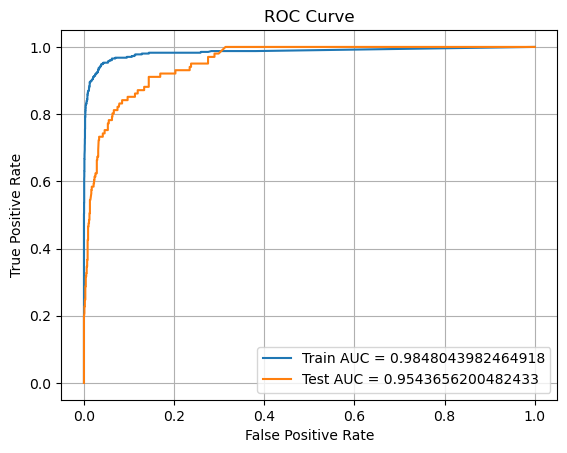

The maximum value of tpr*(1-fpr) 0.9121364035460391 for threshold 0.245
Model test F1 score is :  0.6558704453441295
Model test AUC score is :  0.9543656200482433


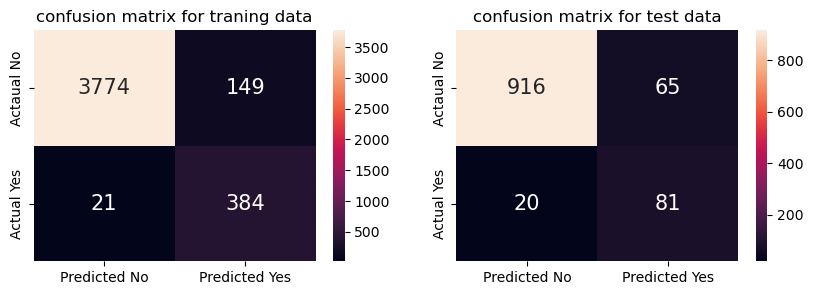

In [34]:
model_f1_score, model_AUC_score = model_performance_check(XGB2,X_train,X_test,y_train,y_test)

In [37]:
from sklearn.ensemble import RandomForestClassifier

rfc_6 = RandomForestClassifier(
    n_estimators=30,
    criterion='gini',
    max_depth= 4,
    max_features='auto',
    min_samples_leaf=100,
    min_samples_split=50,
    random_state=49,
    min_weight_fraction_leaf=0.0,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    ccp_alpha=0.0
    )

rfc_6.fit(X_train_scaled, y_train)

RandomForestClassifier(max_depth=4, min_samples_leaf=100, min_samples_split=50,
                       n_estimators=30, random_state=49)

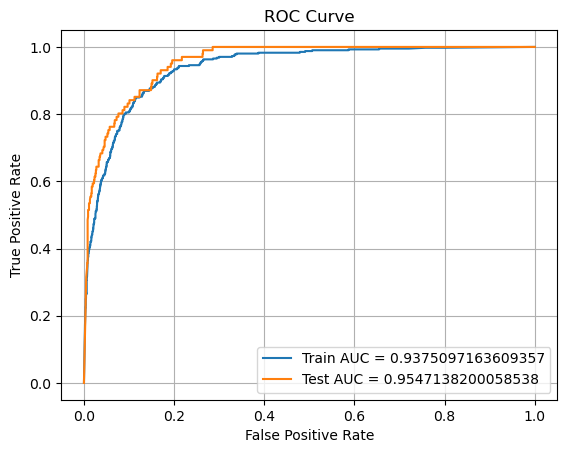

The maximum value of tpr*(1-fpr) 0.7534873474885371 for threshold 0.114
Model test F1 score is :  0.5382262996941896
Model test AUC score is :  0.9547138200058538


### Model AUC is : 0.9547
### Model Train F1 Score is : 0.5382


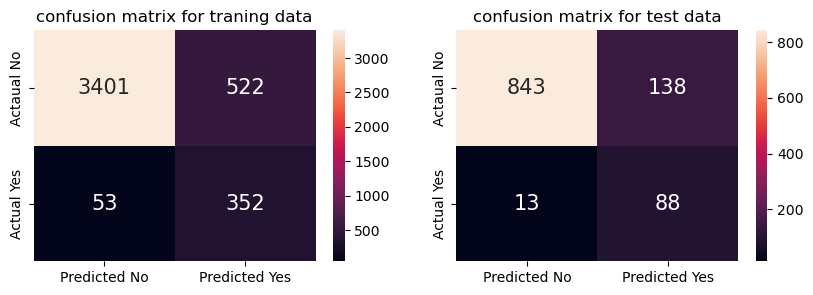

In [38]:
model_f1_score, model_AUC_score = model_performance_check(rfc_6,X_train_scaled, X_test_scaled, y_train, y_test)

print("\n")
print("### Model AUC is : {:.4f}".format(model_AUC_score))
print("### Model Train F1 Score is : {:.4f}".format(model_f1_score))